# Plots for paper

In [1]:
using Pkg
#Pkg.rm("PartonDensity")
#Pkg.add(url="https://github.com/cescalara/PartonDensity.jl.git")
Pkg.instantiate()

┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/fran/projects/high-x-parton-pdf-inference/Manifest.toml:0


In [14]:
using BAT, Plots, PartonDensity, DelimitedFiles, StatsBase, Distributions, Printf
import HDF5

gr(fmt=:png); 

Load data, results and set up parameters

In [3]:
# Data
counts_ep = readdlm("eP.dat") 
counts_em = readdlm("eM.dat")
nbins = length(counts_ep)

# Results
samples = bat_read("Data-Dirichlet-sysrun-priors-tight.h5").result;

# As in PDF-fit-dirichlet.ipynb
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, 
                         spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();

Set up color scheme and aesthetic things

In [12]:
color_scheme = :viridis
font_family = "Computer Modern"
Plots.scalefontsizes()
Plots.scalefontsizes(1.2);


## Figure 1

First, separate data out into unique $Q^2$ bins

In [8]:
q2_edges_all = Any[]
x_edges_all = Any[]
for i in 1:nbins
    (q2_edges, x_edges) = get_bin_info(i, quiet=true);
    push!(q2_edges_all, q2_edges)
    push!(x_edges_all, x_edges)
end

q2_edges_unique = copy(q2_edges_all)
n_q2_bins = length(unique!(q2_edges_unique))

# get x, counts for each q2 range
counts_em_qsel = Any[]
counts_ep_qsel = Any[]
x_values = Any[]
for q2r in 1:n_q2_bins
    bin_sel = findall(==(q2_edges_unique[q2r]), q2_edges_all)
    push!(counts_em_qsel, counts_em[bin_sel])
    push!(counts_ep_qsel, counts_ep[bin_sel])
    push!(x_values, [mean(_) for _ in x_edges_all[bin_sel]])
end

Now initialise and run the forward model for each sample

NB: Assumes SysErr version for all steps

In [9]:
Ns = 200 # Number of samples from posterior
sub_samples = BAT.bat_sample(samples, BAT.OrderedResampling(nsamples=Ns)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/f4aNp/src/algotypes/bat_default.jl:44


In [7]:
forward_model_init_sysErr(qcdnum_grid, qcdnum_params, splint_params)

counts_em_sampled = zeros(UInt64, (length(sub_samples), nbins))
counts_ep_sampled = zeros(UInt64, (length(sub_samples), nbins))
for s in eachindex(sub_samples)

    pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=samples.v.K_d[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))
    
    par_errs_s = [sub_samples.v.beta0_1[s], sub_samples.v.beta0_2[s], 
                  sub_samples.v.beta0_3[s], sub_samples.v.beta0_4[s], 
                  sub_samples.v.beta0_4[s], sub_samples.v.beta0_5[s],
                  sub_samples.v.beta0_6[s], sub_samples.v.beta0_7[s], 
                  sub_samples.v.beta0_8[s]]
    
    counts_ep_pred_s, counts_em_pred_s = forward_model_sysErr(pdf_params_s,    
                                                              qcdnum_params, 
                                                              splint_params,
                                                              quark_coeffs, 
                                                              par_errs_s)
    
    for j in 1:nbins
        
        counts_ep_pred_s[j] *= 1 + 0.018 * sub_samples.v.Beta1[s]
        counts_em_pred_s[j] *= 1 + 0.018 * sub_samples.v.Beta2[s]
        
        counts_em_sampled[s, j] = rand(Poisson(counts_em_pred_s[j]))
        counts_ep_sampled[s, j] = rand(Poisson(counts_ep_pred_s[j]))
        
    end
    
end

  +---------------------------------------------------------------------+   
  |                                                                     |   
  |    If you use QCDNUM, please refer to:                              |   
  |                                                                     |   
  |    M. Botje, Comput. Phys. Commun. 182(2011)490, arXiV:1005.1481    |   
  |                                                                     |   
  +---------------------------------------------------------------------+   
  
  

 FILLWT: start unpolarised weight calculations
 Subgrids    3 Subgrid points   15   50   75
 Pij LO
 Pij NLO
 Pij NNLO
 Aij LO
 Aij NLO
 Aij NNLO
 FILLWT: weight calculations completed


 ZMFILLW: start weight calculations   4  38   0   0
 ZMFILLW: calculations completed

  +---------------------------------------+
  | You are using SPLINT version 20220308 |
  +---------------------------------------+


0.00019953
0.00016954
0.00019447
1.752500000000

In [10]:
# Use +2 to avoid lightest colors (not easy to see)
cmap = palette(color_scheme, n_q2_bins+2); 

Make plot

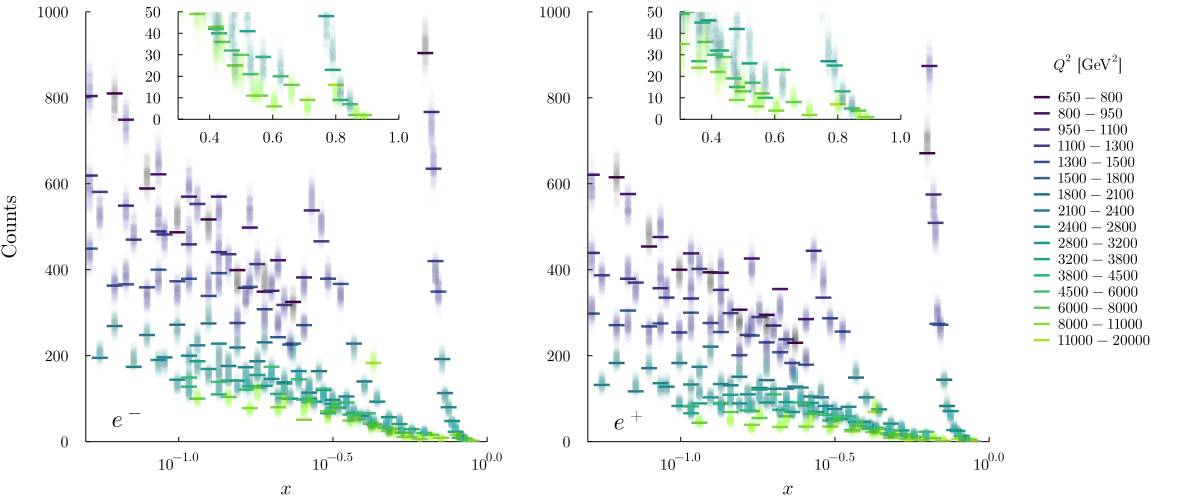

In [25]:
plot(framestyle=:axes, size=(1200, 500), fontfamily=font_family, 
    leftmargin=5Plots.mm, bottommargin=5Plots.mm, rightmargin=5Plots.mm,
    layout=@layout([a b c{0.15w}]),)

plot!(inset=(1, bbox(0.23, 0.75, 0.55, 0.25, :bottom)))
plot!(inset=(2, bbox(0.23, 0.75, 0.55, 0.25, :bottom)))

plot!(xlim=(5e-2, 1), ylim=(0, 1000), xlabel="\$x\$", ylabel="Counts", xscale=:log, 
    grid=false, legend=:false, foreground_color_legend=nothing,
    legendfontsize=10, thickness_scaling=1, xticks=[0.1, 10^-0.5, 1.0], subplot=1)
plot!(xlim=(5e-2, 1), ylim=(0, 1000), xlabel="\$x\$", ylabel="", xscale=:log, 
    grid=false, legend=false, xticks=[0.1, 10^-0.5, 1.0], subplot=2)

for sp in [4, 5]
    plot!(xlim=(0.3, 1.0), ylim=(0, 50), grid=false, subplot=sp)
end

# Data
for i in 1:n_q2_bins

    label = @sprintf "  \$%g - %g\$" q2_edges_unique[i][1] q2_edges_unique[i][2]

    # Main plots and inset plots
    scatter!(x_values[i], counts_em_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=2.5, markersize=8, m=:hline, subplot=1)
    scatter!(x_values[i], counts_ep_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=2.5, markersize=8, m=:hline, subplot=2)
    scatter!(x_values[i], counts_em_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=2.5, markersize=8, m=:hline, subplot=4)
    scatter!(x_values[i], counts_ep_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=2.5, markersize=8, m=:hline, subplot=5)
    
    # For legend (invisible, trick to create space)
    scatter!(x_values[i], counts_em_qsel[i], label=label, color=cmap[i], 
        markerstrokewidth=2.5, markersize=8, m=:hline, subplot=3)

end

# Samples
for s in eachindex(sub_samples)
    
    counts_em_s = Any[]
    counts_ep_s = Any[]
    for q2r in 1:n_q2_bins
        bin_sel = findall(==(q2_edges_unique[q2r]), q2_edges_all)
        push!(counts_em_s, counts_em_sampled[s, bin_sel])
        push!(counts_ep_s, counts_ep_sampled[s, bin_sel])
    end
    
    for i in 1:n_q2_bins
        
        scatter!(x_values[i], counts_em_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=1)
        scatter!(x_values[i], counts_ep_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=2)
        scatter!(x_values[i], counts_em_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=4)
        scatter!(x_values[i], counts_ep_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=5)
        
    end
    
end

plot!(legend=:left, foreground_color_legend=nothing, framestyle=:none,
    subplot=3, xlim=(1,2), ylim=(0, 1000), legendfontsize=10, thickness_scaling=1,
    left_margin=-10Plots.mm)
annotate!(1.4, 880, text("\$Q^2\$ [GeV\$^2\$]", 10, font_family), subplot=3)
annotate!(0.07, 50, text("\$e^-\$", 16, font_family), subplot=1)
p = annotate!(0.07, 50, text("\$e^+\$", 16, font_family), subplot=2)
p

Save figure - for some reason PDF messes up the colours - need to check.

In [27]:
savefig(p, "figures/fig1_data_space.png")

## Figure 2

Coming soon!